# Using LSTM for Sequence to Sequence Predictions

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
tf.random.set_seed(0)

2023-01-02 16:58:31.442138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv')

In [3]:
df.head(3)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [4]:
print('size of dataset:', len(df))

size of dataset: 144


# Plot the Series to see Trend and Seasonality

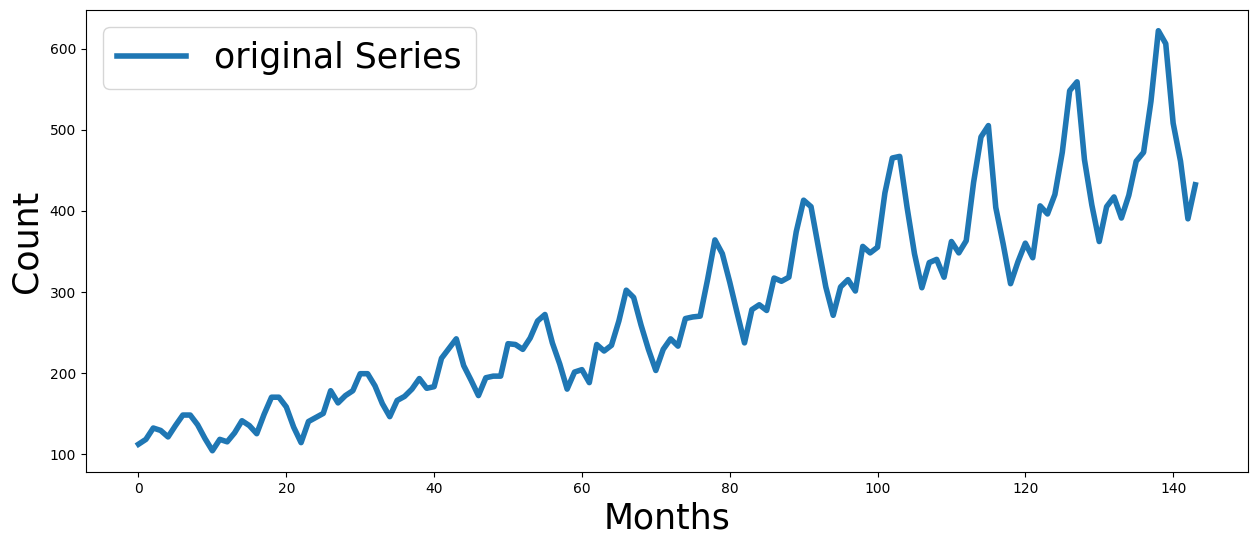

In [5]:
from matplotlib import pyplot as plt
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
plt.plot(df['#Passengers'], linewidth = 4, label = "original Series")
plt.legend(fontsize=25)
plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
plt.show()

# Convert it into a Sequence to Sequence Prediction Problem

In [6]:
def Tranform_dataset(input_length, output_length, data):
    
    df = data.copy()
    
    #input columns creation
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['#Passengers'].shift(-i)
        i = i + 1
    
    #output columns creations
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['#Passengers'].shift(-output_length-j)
        j = j + 1
    
    #drop some of the last columns
    df = df.dropna(axis=0)
    
    return df

In [7]:
history = 12 #last values used by model
future = 6 #predict future values

full_data = Tranform_dataset(history, future, df)
print(len(full_data))

133


In [8]:
full_data.head()

,Month,#Passengers,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,y_0,y_1,y_2,y_3,y_4,y_5
0,1949-01,112,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,148.0,148.0,136.0,119.0,104.0,118.0
1,1949-02,118,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,148.0,136.0,119.0,104.0,118.0,115.0
2,1949-03,132,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,136.0,119.0,104.0,118.0,115.0,126.0
3,1949-04,129,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,119.0,104.0,118.0,115.0,126.0,141.0
4,1949-05,121,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,104.0,118.0,115.0,126.0,141.0,135.0


# X, Y: Full dataset

In [9]:
X_cols = [col for col in full_data.columns if col.startswith('x')]
X_cols.insert(0, '#Passengers')

y_cols = [col for col in full_data.columns if col.startswith('y')]
X = full_data[X_cols].values
y = full_data[y_cols].values

print(X.shape, y.shape)

(133, 12) (133, 6)


# Train Test Random Split (Shuffle=True)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], history, 1)
X_test = X_test.reshape(X_test.shape[0], history, 1)
print(X_train.shape, X_test.shape)

(106, 12, 1) (27, 12, 1)


# Train Baseline LSTM Model

In [14]:
def get_model(history, future):
    model = Sequential()
    model.add(LSTM(12, input_shape=(history, 1), return_sequences=True, activation='relu'))
    model.add(LSTM(12, return_sequences=False, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(future))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [15]:
model = get_model(history, future)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 12)            672       
                                                                 
 lstm_3 (LSTM)               (None, 12)                1200      
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 6)                 78        
                                                                 
Total params: 2,106
Trainable params: 2,106
Non-trainable params: 0
_________________________________________________________________


In [16]:
filepath = 'LSTM_Example_1.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [17]:
hist = model.fit(X_train, y_train, epochs=2000, batch_size=16, verbose=0, validation_data=(X_test, y_test), shuffle=True, callbacks = callbacks)

In [18]:
print(hist.history.keys())

dict_keys(['loss', 'val_loss'])


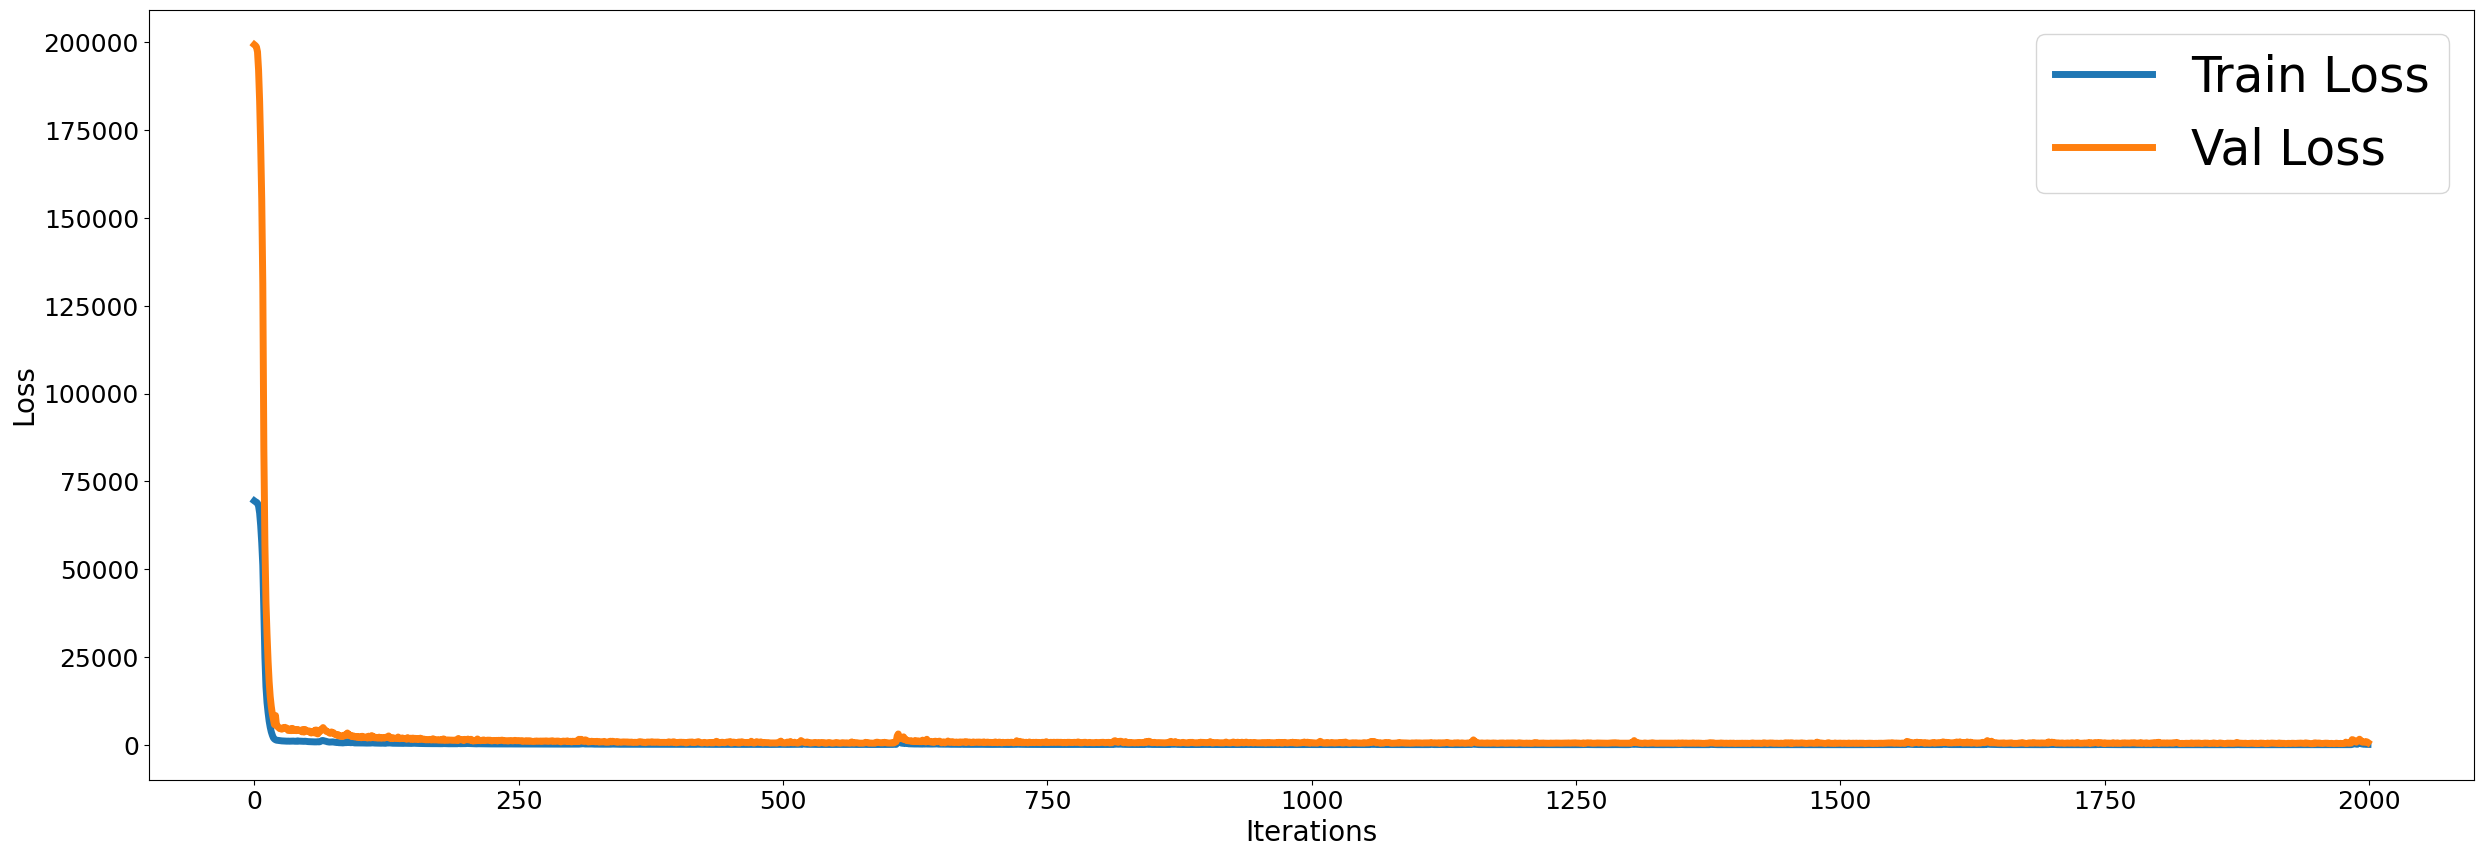

In [19]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(hist.history['loss'], label = "Train Loss", lw=5)
plt.plot(hist.history['val_loss'], label = "Val Loss", lw=5)

plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)

plt.legend(fontsize = 35)
plt.show()

In [20]:
model.load_weights(filepath)

In [21]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 154ms/step


# Combine predictions on all the data

In [22]:
y_pred_all = model.predict(X.reshape(X.shape[0], history, 1)) 

5/5 [==============================] - 0s 3ms/step


In [23]:
pred = []
truth = []

for i in range(len(y_pred_all)):
    if i==(len(y_pred_all)-1):
        for j in range(len(y_pred_all[i])):
            pred.append(y_pred_all[i][j])
            truth.append(y[i][j])    
    else:
        pred.append(y_pred_all[i][0])
        truth.append(y[i][0])


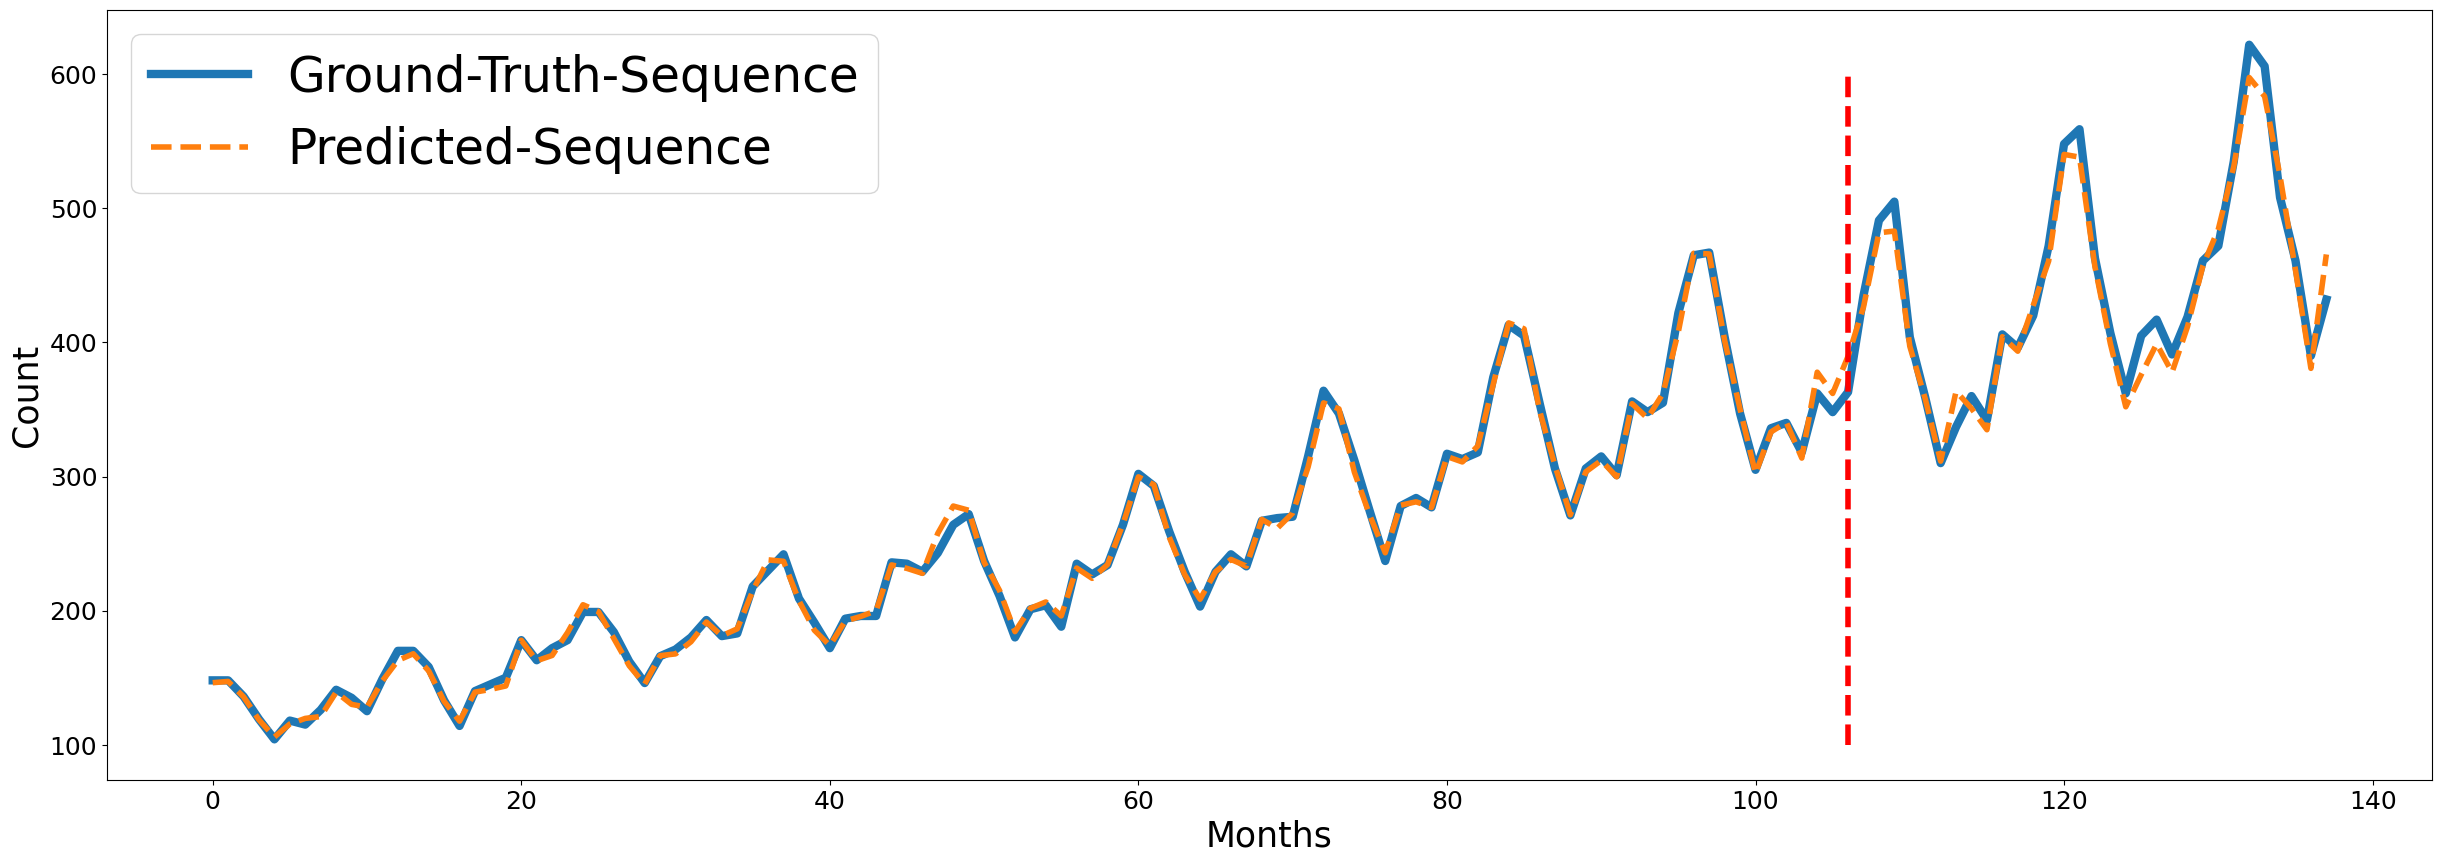

In [24]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(truth,label='Ground-Truth-Sequence', lw=6)
plt.plot(pred,label='Predicted-Sequence', lw=4, linestyle='dashed')

plt.vlines(x=len(y_train), ymin=100, ymax = 600, lw=4, linestyle='dashed', color='r')

plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)

plt.legend(fontsize = 35)
plt.show()